<a href="https://colab.research.google.com/github/patrickangeli/INF-420/blob/main/CLASSIFICATION_FINAL_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys 
import time
import os
import pandas as pd
import numpy as np
import matplotlib
import xgboost as xgb
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import warnings


In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression as LR
from xgboost.sklearn import XGBClassifier as XGB

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
#from sklearn.grid_search import RandomizedSearchCV
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, precision_score, accuracy_score, recall_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
import joblib
from sklearn.utils import shuffle
from sklearn.feature_selection import chi2
from scipy import interp

In [ ]:
#global_variables
K_folds = 5 
results = {'f1_weighted': [], 'recall': [], 'precision': [], 'accuracy_score': [], 'auc': [], 'f1_macro': [], 'f1':[], 'error':[]}
feature_importance = True # perform feature importance calculation using RF and chi2
plot_roc_curve = True
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)



In [ ]:
def statistics(data):
        if data:
            avg = np.average(data)
            sd = [(elem - avg)**2 for elem in data]
            sd = sum(sd)/float(len(data))
            sd = np.sqrt(sd)
            std = np.std(data)
            error = 1.96 * sd/float(np.sqrt(len(data))) # 95% of confidence level
            median = np.median(data)
            #max_ = np.max(data)
            #min_ = np.min(data)
            print("IC 95%%: %f +- %f" %(avg, error))
        else:
            print("Not.")


In [ ]:
def statistics(data):
        if data:
            avg = np.average(data)
            sd = [(elem - avg)**2 for elem in data]
            sd = sum(sd)/float(len(data))
            sd = np.sqrt(sd)
            std = np.std(data)
            error = 1.96 * sd/float(np.sqrt(len(data))) # 95% of confidence level
            median = np.median(data)
            #max_ = np.max(data)
            #min_ = np.min(data)
            print("IC 95%%: %f +- %f" %(avg, error))
        else:
            print("Not.")



In [ ]:
def feature_preparation(characteristics):
    ########################### FEATURE PREPARATION ###############################
    feature_types = { #type
            'content': ['WC', 'Analytic', 'Clout', 'Authentic', 'Tone', 'WPS', 'Sixltr', 'Dic', 'function', 'pronoun', 'ppron', 'i', 'we', 'you',
                  'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number',
                  'quant', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'social', 'family', 'friend', 'female', 'male', 'cogproc',
                  'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'percept', 'see', 'hear', 'feel', 'bio', 'body', 'health', 'sexual',
                  'ingest', 'drives', 'affiliation', 'achieve', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'relativ',
                  'motion', 'space', 'time', 'work', 'leisure', 'home', 'money', 'relig', 'death', 'informal', 'swear', 'netspeak', 'assent',
                  'nonflu', 'filler', 'AllPunc', 'Period', 'Comma', 'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash', 'Quote', 'Apostro', 'Parenth', 'OtherP'],

            'source': ['cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'percept', 'see', 'hear', 'feel'],

            'environment': ['page', 'low_credibility', 'domain', 'ranking_position_alexa', 'sequenceMatcher_top_newspapers_alexa', 'page_talking_about_count', 'page_fan_count', 'ip', 'latitude', 'longitude','type']    
    }
    
    features = []
    if characteristics == "content":
            features.extend(feature_types['content'])
    if characteristics == "source":
            features.extend(feature_types['source'])
    if characteristics == "environment":
            features.extend(feature_types['environment'])
    if characteristics == "all":
            features.extend(feature_types['content'])
            features.extend(feature_types['source'])
            features.extend(feature_types['environment'])
    return features

In [ ]:
def feature_importance_RF(X,y):
########################### FEATURE IMPORTANCE ################################
# feature importance calculation
  clf = RF(n_estimators=200)
  clf.fit(X, y)

  importances = clf.feature_importances_
  print(importances)
  std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
  indices = np.argsort(importances)[::-1]
#Print the feature ranking
  print ("Feature ranking:")

  #for f in range(X.shape[1]):
  #       print ("%d. feature %d (%f)" % f + 1, importances[indices[f]])

    #Plot the feature importances of the clf
  plt.figure()
  plt.title("Feature importances")
  plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
  plt.xticks(range(X.shape[1]), indices)
  plt.xlim([-1, X.shape[1]])
  plt.show()
  plt.savefig("/content/drive/MyDrive/IC/"+"feature_importance")
  plt.clf()


In [ ]:
def feature_importance_chi2(X,y):
 global K_folds
 # http://www.handsonmachinelearning.com/blog/2AeuRL/chi-square-feature-selection-in-python
 X = X.abs() #change negative values to positive
 result_chi2 = chi2(X,y)
 rank_chi2 = SelectKBest(score_func=chi2,k=0)
 result_chi2 = rank_chi2.fit(X,y)
 #print (result_chi2.scores)
 features_chi2 = result_chi2.transform(X)
 print (features_chi2)


In [ ]:
def main():
    global K_folds
    global results
    global tprs
    global aucs
    global mean_fpr
    #param = sys.argv[1:]
    #clf_type = param[0]
    #target = param[1]
    #dataset = param[2]
    #characteristics = param[3]
    #python3 NB label bla.csv all
    #manual definition
    clf_type = "XGB" #classificador
    target = "rating"  #nome do label no dataframe
    dataset = "brazil_whatsapp.csv" #nome do arquivo - dataset
    characteristics = "all" #grupo de features

    # set those variables according to your path
    patch = '/content/drive/MyDrive/IC/'
    inFile = patch + dataset
    print(target)
    #reading dataset
    df_dataset = pd.read_csv(inFile, delimiter = '\t')
    #shuffle 
    #df_dataset = shuffle(df_dataset)

    df_dataset = df_dataset.fillna(df_dataset.median())
 #   print(df_dataset.head())
    #df_dataset = df_dataset.fillna(lambda x: x.median())

    #Convert to categorical data by converting data to integers
    if df_dataset['rating'].dtype != 'int':
        labels, uniques = pd.factorize(df_dataset[target])
        df_dataset[target] = labels

    if df_dataset['img_safe_search_medical'].dtype != 'int':
        labels, uniques = pd.factorize(df_dataset['img_safe_search_medical'])
        df_dataset['img_safe_search_medical'] = labels

    if df_dataset['sentiment'].dtype != 'int':
        labels, uniques = pd.factorize(df_dataset['sentiment'])
        df_dataset['sentiment'] = labels

    if df_dataset['first_group'].dtype != 'int':
        labels, uniques = pd.factorize(df_dataset['first_group'])
        df_dataset['first_group'] = labels
      
    if df_dataset['img_safe_search_spoof'].dtype != 'int':
        labels, uniques = pd.factorize(df_dataset['img_safe_search_spoof'])
        df_dataset['img_safe_search_spoof'] = labels
		
    if df_dataset['img_similar'].dtype != 'int':
        labels, uniques = pd.factorize(df_dataset['img_similar'])
        df_dataset['img_similar'] = labels		

    if df_dataset['img_objects'].dtype != 'int':
       labels, uniques = pd.factorize(df_dataset['img_objects'])
       df_dataset['img_objects'] = labels

    if df_dataset['img_labels'].dtype != 'int':
       labels, uniques = pd.factorize(df_dataset['img_labels'])
       df_dataset['img_labels'] = labels

    if df_dataset['img_web_entities'].dtype != 'int':
       labels, uniques = pd.factorize(df_dataset['img_web_entities'])
       df_dataset['img_web_entities'] = labels   

    if df_dataset['img_safe_search_adult'].dtype != 'int':
       labels, uniques = pd.factorize(df_dataset['img_safe_search_adult'])
       df_dataset['img_safe_search_adult'] = labels

    if df_dataset['img_safe_search_racy'].dtype != 'int':
       labels, uniques = pd.factorize(df_dataset['img_safe_search_racy'])
       df_dataset['img_safe_search_racy'] = labels

    if df_dataset['img_safe_search_violence'].dtype != 'int':
       labels, uniques = pd.factorize(df_dataset['img_safe_search_violence'])
       df_dataset['img_safe_search_violence'] = labels   

#    df_dataset = df_dataset.astype(bool)

        

    
    feat_cols = feature_preparation(characteristics)
    
#    if df_dataset.dtypes == 'float64':
#      df_dataset = df_dataset.astype(bool)
#    feat_cols = ['img_similar','sentiment','toxicity','count_low_word','count_up_word','political_bias_mainstream','readability_gunning_fog','sentence_info_sentences','sentence_info_syll_per_word','subjectivity','sentence_info_words','readability_linsear_write_formula', 'readability_smog_index','word_usage_preposition','word_usage_auxverb','readability_dale_chall_readability_score','sentence_info_complex_words_dc','word_usage_pronoun','sentence_info_syllables','sentence_info_type_token_ratio','sentence_info_complex_words','sentence_info_characters','readability_difficult_words','img_objects','img_web_entities','img_labels','img_safe_search_medical','img_safe_search_violence','img_safe_search_spoof','img_safe_search_adult','img_safe_search_racy'] #content
#    feat_cols = ['img_similar','sentiment','toxicity','count_low_word','count_up_word','political_bias_mainstream','readability_gunning_fog','sentence_info_sentences','sentence_info_syll_per_word','subjectivity','sentence_info_words','readability_linsear_write_formula', 'readability_smog_index','word_usage_preposition','word_usage_auxverb','readability_dale_chall_readability_score','sentence_info_complex_words_dc','word_usage_pronoun','sentence_info_syllables','sentence_info_type_token_ratio','sentence_info_complex_words','sentence_info_characters','readability_difficult_words','img_objects','img_web_entities','img_labels','img_safe_search_medical','img_safe_search_violence','img_safe_search_spoof','img_safe_search_adult','img_safe_search_racy', 'DDD_localiz_user_first_share','first_user','count_groups','count_web_dissemination_urls','count_web_dissemination_domain','first_group','group_creator','web_dissem_foreign_uncommon_domains','political_bias_right','political_bias_left', 'affect','feel','friend','social','humans','web_dissem_domain_https','web_dissem_accessible_links','web_dissem_foreign_uncommon_domains','count_shares'] #all_features
#    feat_cols = ['DDD_localiz_user_first_share','first_user','count_groups','count_web_dissemination_urls','count_web_dissemination_domain','first_group','group_creator','web_dissem_foreign_uncommon_domains','political_bias_right','political_bias_left'] #source
#    feat_cols = ['img_similar','sentiment','toxicity','count_low_word','count_up_word','political_bias_mainstream','readability_gunning_fog','sentence_info_sentences','sentence_info_syll_per_word','subjectivity','sentence_info_words','readability_linsear_write_formula', 'readability_smog_index','word_usage_preposition','word_usage_auxverb','readability_dale_chall_readability_score','sentence_info_complex_words_dc','word_usage_pronoun','sentence_info_syllables','sentence_info_type_token_ratio','sentence_info_complex_words','sentence_info_characters','readability_difficult_words','img_objects','img_web_entities','img_labels','img_safe_search_medical','img_safe_search_violence','img_safe_search_spoof','img_safe_search_adult','img_safe_search_racy','DDD_localiz_user_first_share','first_user','count_groups','count_web_dissemination_urls','count_web_dissemination_domain','first_group','group_creator','web_dissem_foreign_uncommon_domains','political_bias_right','political_bias_left'] #conteudo+fonte
#    feat_cols = ['affect','feel','friend','social','humans','web_dissem_domain_https','web_dissem_accessible_links','web_dissem_foreign_uncommon_domains','count_shares'] #ambiente
    feat_cols = ['img_similar','sentiment','toxicity','count_low_word','count_up_word','political_bias_mainstream','readability_gunning_fog','sentence_info_sentences','sentence_info_syll_per_word','subjectivity','sentence_info_words','readability_linsear_write_formula', 'readability_smog_index','word_usage_preposition','word_usage_auxverb','readability_dale_chall_readability_score','sentence_info_complex_words_dc','word_usage_pronoun','sentence_info_syllables','sentence_info_type_token_ratio','sentence_info_complex_words','sentence_info_characters','readability_difficult_words','img_objects','img_web_entities','img_labels','img_safe_search_medical','img_safe_search_violence','img_safe_search_spoof','img_safe_search_adult','img_safe_search_racy', 'affect','feel','friend','social','humans','web_dissem_domain_https','web_dissem_accessible_links','web_dissem_foreign_uncommon_domains','count_shares'] #cont+amb
#    feat_cols = ['DDD_localiz_user_first_share','first_user','count_groups','count_web_dissemination_urls','count_web_dissemination_domain','first_group','group_creator','web_dissem_foreign_uncommon_domains','political_bias_right','political_bias_left','affect','feel','friend','social','humans','web_dissem_domain_https','web_dissem_accessible_links','web_dissem_foreign_uncommon_domains','count_shares'] #font+amb
        
    print ('\nFeatures that will be used:\n')
    for idx, feat in enumerate(feat_cols):
        print (idx+1, feat)

 #   print ("Dataset = " + dataset)
 #   print ("Features = " + characteristics)
 #  print ("Classifier = " + clf_type)
 #   print ("Target = " + target)


    X = df_dataset[feat_cols]
    #print (X)
    y = df_dataset[target]
    #X = df_dataset[feat_cols].dtype
    #y = df_dataset[target].dtype
        

    ########################### FEATURE IMPORTANCE ################################

    if feature_importance:
            print ("feature importance RF calculation")
            feature_importance_RF(X,y)
            print ("chi2 calculation")
            feature_importance_chi2(X,y)

		########################### CLASSIFICATION EXPERIMENT ##############################
		
        #K-Folds cross-validator
    kf = KFold(n_splits=K_folds, shuffle=True, random_state=1)
    skf = StratifiedKFold(n_splits=K_folds, shuffle=True, random_state=1)
    kf.get_n_splits(X)
    skf.get_n_splits(X, y)
    X = X.values
    y = y.values

            #for train_index, test_index in kf.split(X):
    for train_index, test_index in skf.split(X,y):
        #print("Train:", train_index, "Test:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        scale = True  # set to True if you want to perform scaling of the dataset
        serialize = False  # set to True if you want to serialize trained model to file


     # choose the classifier type. One of the options bellow
    estimators = {
              'SVM': SVC,
              'SVM_linear': LinearSVC,
              'RF': RF,
              'KNN': KNN,
              'NB': BernoulliNB,
              'AdaBoost': AdaBoostClassifier,
              'LR': LR,
              'Bagging': BaggingClassifier(base_estimator=SVC(C=100000)),
              'Bagging_RF': BaggingClassifier(base_estimator=RF()),
              'XGB': XGB,
              }

        ############################ DATA PREPROCESSING ###############################

        # scaling
    if scale==True or clf_type=='SVM' or clf_type=='SVM_linear':
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)

        ##################### HYPERPARAMETER TUNING & TRAINING ########################
    if clf_type == 'RF':
            tuning_parameters = {'criterion': ['gini', 'entropy'],
                                'n_estimators': [20, 250],
                                'max_features': ['auto', 'sqrt', 'log2', None],
                                'min_samples_split': [2, 4],
                                'min_samples_leaf': [2, 5, 10],
                                'n_jobs': [-1]}

    elif clf_type == 'SVM':
            tuning_parameters = {'kernel': ['rbf'],
                                'gamma': [1e-1, 1e-3, 1e-5],
                                'C': [0.01, 1, 100, 1000],
                                #'n_jobs': [-1]
                                'probability': [True]
                  }

    elif clf_type == 'SVM_linear':
            tuning_parameters = {'tol': [1e-1, 1e-4, 1e-5],
                                #'C': [0.01, 1, 100, 1000],
                                'C': [1000000000000],
                                'penalty': ['l2']
                                #'penalty': ['l1', 'l2']
                                #'n_jobs': [-1]
                                }

    elif clf_type == 'AdaBoost':
            tuning_parameters = {'n_estimators': [20, 50, 250],
                                'learning_rate': [0.01, 0.1, 1, 10]
                                }
    elif clf_type == 'KNN':
            tuning_parameters = {'n_neighbors': [5, 15, 30, 60],
                                  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                                  'n_jobs': [-1]}
                                #{'algorithm': ['auto', 'brute'], 'n_jobs': [-1]}]

    elif clf_type == 'NB':
            tuning_parameters = {'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2, 1e-1,
                                          1, 1e2, 1e4, 1e6]}

    elif clf_type == 'LR':
            tuning_parameters = {'penalty': ['l1', 'l2'],
                                'C': [0.01, 1, 10, 100],
                                'tol': [1e-1, 1e-4, 1e-5],
                                'n_jobs': [-1]}

    elif clf_type == 'XGB':
            tuning_parameters = {'learning_rate': [0.1],
                                'n_estimators': [100],
                                'max_depth': [5,6],
                                'min_child_weight': [1],
                                'gamma': [0],
                                'subsample': [0.8,1],
                                'colsample_bytree': [0.8,1],
                                'objective': ['binary:logistic'],
                                'nthread': [4],
                                #'scale_pos_weight': [1],
                                'scale_pos_weight': [0.2091],
                                #'scale_pos_weight': [0.2091,0.4,0.6,0.8,1],
                                'seed': [27, 100, 500, 1000]}

    elif clf_type == 'Bagging':
        tuning_parameters = {'n_estimators': [10, 20, 40, 80, 10, 150, 180, 200, 230, 250],
                            'max_samples': [1.0],
                            'max_features': [1.0],
                            'n_jobs': [-1, 1]}			

        # tune parameters
    print ('\n# Tuning hyperparameters')
    if clf_type == 'Bagging':
        clf = GridSearchCV(estimators[clf_type], tuning_parameters, cv=K_folds-1)
    else:
        clf = GridSearchCV(estimators[clf_type](), tuning_parameters, cv=K_folds-1)
            #clf = RandomizedSearchCV(estimators[clf_type](), tuning_parameters, cv=K_folds-1)

    clf.fit(X_train, y_train)  #train
    print ('\nBest parameters set found on development set:')
    print (clf.best_params_)
    df = pd.DataFrame(clf.cv_results_)

   # print(df.items())
   # for params in df.items():
   #        print ('%0.3f (+/-%0.03f) for %r', params)
   # print ('\n')
   # for mean_score in df.items():
   #        print ('%0.3f (+/-%0.03f) for %r', mean_score)
   # print ('\n')
   # for scores in df.items():
   #        print ('%0.3f (+/-%0.03f) for %r', scores)
   # print ('\n')
   # for params, mean_score, scores in df.items():
   #         print ('%0.3f (+/-%0.03f) for %r', mean_score, (scores*2), params)
   # print ('\n')
    
        ######################### RESULTS & LOGGING ###################################
    print ('Detailed classification report:')
    print ('The model is trained on the k-folds development set.')
    print ('The scores are computed on the k-folds evaluation set.')
    y_true, y_pred = y_test, clf.predict(X_test) 
    mean_absolute_error = cross_val_score(clf, X_test, y_test, scoring='neg_mean_absolute_error') #'neg_mean_squared_error' or 'r2'
    probas_ = clf.predict_proba(X_test)
    print (probas_)
    score = accuracy_score(y_true, y_pred)
    results['accuracy_score'].append(score)
    results['error'].append(1-score)
    auc = roc_auc_score(y_test, probas_[:, 1])
    auc = roc_auc_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
    results['auc'].append(auc)
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    results['f1_weighted'].append(f1_weighted)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    results['f1_macro'].append(f1_macro)
    f1 = f1_score(y_true, y_pred)
    results['f1'].append(f1)
    precision = precision_score(y_true, y_pred, average='weighted')
    results['precision'].append(precision)
    recall = recall_score(y_true, y_pred, average='weighted')
    results['recall'].append(recall)
    print (classification_report(y_true, y_pred))
    print (confusion_matrix(y_true, y_pred))
    print ('acc score:', score)
    print ('auc score:', auc)
    print ('f1:', f1_weighted)
    print ('precision:', precision)
    print ('recall:', recall)
    print ('error:', (1 - score))
    print ("mean_absolute_error: %.3f (%.3f)", mean_absolute_error.mean(), mean_absolute_error.std()) 
    print (mean_absolute_error)
    params = '_'.join([k + ':' + str(v) for k, v in clf.best_params_.items()])
    model_name = clf_type + '_' + target + '_' + '_' + characteristics + '_' + params

        ############################ ROC CURVE ###############################
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    print ("FPRRRRR:", fpr, len(fpr))
  # print (roc_auc)
    aucs.append(auc)
  #  plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold (AUC = %0.2f)' % (roc_auc))
    #plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        ########################### SERIALIZATION #####################################
    if serialize:
            if not os.path.exists('log'):
                os.makedirs('log')
            with open('log/' + model_name + '_time' +str(time.time()) + '.txt', 'wb') as f:
                print >>f, classification_report(y_true, y_pred)
                print >>f, 'acc score:', accuracy_score(y_true, y_pred)
                print >>f, 'roc au score:', roc_auc_score(y_true, y_pred)
                print >>f, confusion_matrix(y_true, y_pred)

            if not os.path.exists('models'):
                os.makedirs('models')
            joblib.dump(clf, 'models/' + model_name + '_score_' + str(score) + '.pkl')

                            #classification_experiment(clf_type, target, characteristics, X_train, y_train, X_test, y_test)
                        #colocar classificador AQUI! 

                 ############################ DATA PREPROCESSING ###############################

    if plot_roc_curve:
               plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Aleatorio', alpha=.8)
               mean_tpr = np.mean(tprs, axis=0)
               mean_tpr[-1] = 1.0
               mean_auc = accuracy_score(y_true, y_pred) #metrics.auc(mean_fpr, mean_tpr)
               std_auc = np.std(aucs)
               plt.plot(mean_fpr, mean_tpr, color='b',
                         label=r'Média (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, mean_absolute_error.mean()),
                         lw=2, alpha=.8)
               std_tpr = np.std(tprs, axis=0)
               tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
               tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
               plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.5,
                       label=r'$\pm$ 1 std. dev.')
               plt.xlim([-0.05, 1.05])
               plt.ylim([-0.05, 1.05])
               plt.xlabel('Taxa de Falsos Positivos (%)')
               plt.ylabel('Taxa de Verdadeiros Positivos (%)')
               plt.title('ROC')
               plt.legend(loc="lower right")
               plt.savefig("/content/drive/MyDrive/IC/plots/todas_features/"+"contamb_roc_curve_"+clf_type+"_"+ characteristics +"_"+ dataset.replace('.csv','')) ## AQUI TEM UMA PASTA PLOT, ETC               
               plt.show()
               plt.clf()
            ########################### STATISTICS ##############################

  #  for metric in results:
  #                      print (metric)
  #                      statistics(results[metric])

rating

Features that will be used:

1 img_similar
2 sentiment
3 toxicity
4 count_low_word
5 count_up_word
6 political_bias_mainstream
7 readability_gunning_fog
8 sentence_info_sentences
9 sentence_info_syll_per_word
10 subjectivity
11 sentence_info_words
12 readability_linsear_write_formula
13 readability_smog_index
14 word_usage_preposition
15 word_usage_auxverb
16 readability_dale_chall_readability_score
17 sentence_info_complex_words_dc
18 word_usage_pronoun
19 sentence_info_syllables
20 sentence_info_type_token_ratio
21 sentence_info_complex_words
22 sentence_info_characters
23 readability_difficult_words
24 img_objects
25 img_web_entities
26 img_labels
27 img_safe_search_medical
28 img_safe_search_violence
29 img_safe_search_spoof
30 img_safe_search_adult
31 img_safe_search_racy
32 affect
33 feel
34 friend
35 social
36 humans
37 web_dissem_domain_https
38 web_dissem_accessible_links
39 web_dissem_foreign_uncommon_domains
40 count_shares
feature importance RF calculation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


[0.03841613 0.01655136 0.05260907 0.04245466 0.04058803 0.01803525
 0.0322388  0.         0.03325211 0.0264469  0.02669813 0.03106032
 0.00485459 0.01729228 0.00521322 0.03330885 0.02574968 0.01277919
 0.02467256 0.02706884 0.01505373 0.03674525 0.02314246 0.02494291
 0.02557965 0.03888259 0.00770162 0.0036675  0.0153128  0.00638318
 0.01073676 0.024      0.01347657 0.0071288  0.02682865 0.0218885
 0.04998995 0.05738082 0.04168093 0.04018735]
Feature ranking:


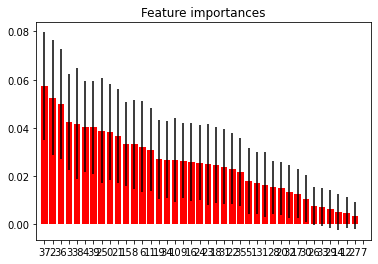

chi2 calculation
[]

# Tuning hyperparameters


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_base.py:99: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning,



Best parameters set found on development set:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'nthread': 4, 'objective': 'binary:logistic', 'scale_pos_weight': 0.2091, 'seed': 27, 'subsample': 0.8}
Detailed classification report:
The model is trained on the k-folds development set.
The scores are computed on the k-folds evaluation set.
[[0.9977954  0.0022046 ]
 [0.99830854 0.00169144]
 [0.99878824 0.00121177]
 ...
 [0.9950921  0.00490791]
 [0.998653   0.00134698]
 [0.9925952  0.00740478]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       877
           1       0.00      0.00      0.00        27

    accuracy                           0.97       904
   macro avg       0.49      0.50      0.49       904
weighted avg       0.94      0.97      0.96       904

[[877   0]
 [ 27   0]]
acc score: 0.9701327433628318
auc score: 0.5
f1: 0.9554255091849563
precision: 0.94

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

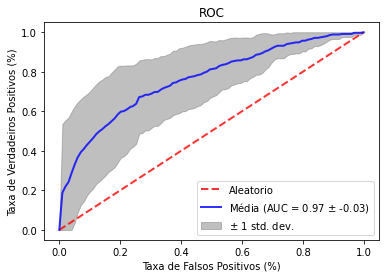

<Figure size 432x288 with 0 Axes>

In [ ]:
main()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
